# Modeling for Capstone Two: Music & Happiness

<div class="alert alert-block alert-danger">
    <b>Make sure to update TOC when you're finished.</b>
</div>

### Table of Contents

* [Introduction](#start)
    * [Goal](#goal)
    * [Import relevant libraries](#import)
    * [Load variables from pre-processing \& training phase](#load)
* [Modeling with Linear Regression](#linear-regression)
    * [Training and fitting](#lr-train)
    * [Residual analysis](#lr-residual)
    * [Scatterplot of predictions vs. actual values](#lr-scatter)
* [Modeling with Random Forest Regression](#random-forest)
    * [Training and fitting](#rf-train)
    * [Residual analysis](#rf-residual)
    * [Scatterplot of predictions vs. actual values](#rf-scatter)
* [Modeling with Gradient Boosting Regressor](#gbr)
    * [Training and fitting](#gbr-train)
    * [Residual analysis](#gbr-residual)
    * [Scatterplot of predictions vs. actual values](#gbr-scatter)
* [Model comparison and evaluation](#comparison)
* [Analysis](#analysis)

## 1 - Introduction <a name="start"></a>

### 1.1 Goal <a name="goal"></a>
Previously, we explored Spotify user metrics from 71 countries and their potential relationships to measures from the 2023 World Happiness Report. Our goal is to determine whether any of these metrics - or perhaps a combination of them - effectively predict how a country might rank on the ladder score of the World Happiness Report. 

#### About the Ladder Score
As previously mentioned in our exploratory data analysis section, the "ladder score" is the "national average response to the question of life evaluations." This is how each survey respondent answered the question, "Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?" (This definition comes directly from the statistical appendix of the 2023 World Happiness Report (WHR), which can be found on the official [World Happiness Report website](https://happiness-report.s3.amazonaws.com/2023/WHR+23_Statistical_Appendix.pdf).)

### 1.2 Import relevant libraries <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 1.3 Load variables from pre-processing and training phase <a name="load"></a>
Previously, we split and trained our data in preparation for creating our model. We stored these variables as `X_train`, `X_test`, `y_train`, and `y_test`. We will retrieve them here:

In [2]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test
%store -r df

## 2 - Modeling with Linear Regression <a name="linear-regression"></a>

### 2.1 Training and fitting <a name="lr-name"></a>

In [3]:
# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Fit the model to the training data
lin_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lin_reg.predict(X_test)

# Evaluate the model using MAE, MSE, and R-squared
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Linear Regression Results:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")

Linear Regression Results:
MAE: 0.6025407258728585
MSE: 0.5466699818463544
R-squared: -0.03191182146676108


#### Interpretation of results
The $R^2$ coefficient, also known as the "coefficient of determination," is a measure of how successfully our model predicts our data's variation from the mean. A score of $1.0$ would indicate a perfect model that explains 100% of the variation.

Our $R^2$ of =0.03191 suggests that the linear regression model does not follow the trend of data. A negative $R^2$ is not acceptable for our analysis, so we will **not** be proceeding with this model.

### 2.2 Residual analysis <a name="lr-residual"></a>

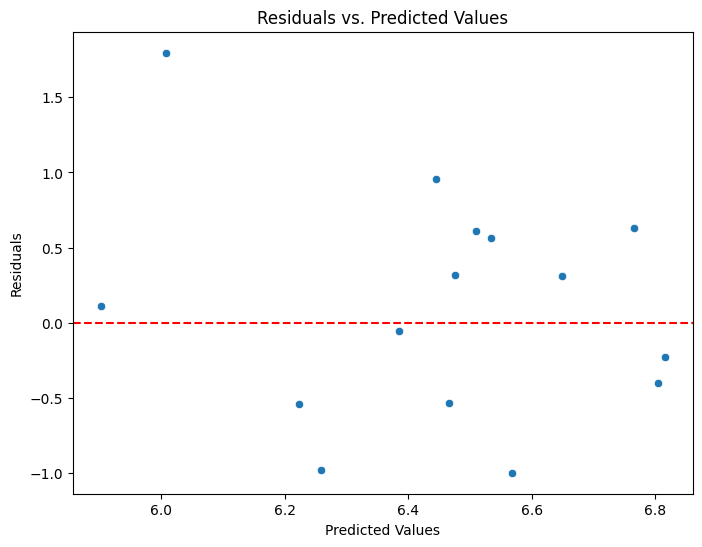

In [4]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Residuals for this model seem to be randomly scattered but are not evenly distributed. Residuals are clustered between 6.2 and 6.8, suggesting the model is not capturing enough variability in the target variable. We would likely benefit from a more complex model.

### 2.3 Scatterplot of predictions vs. actual values <a name="lr-scatter"></a>

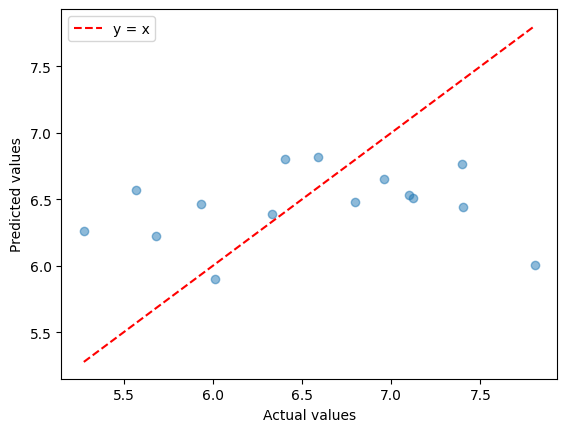

In [5]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

min_val = min(min(y_test), min(y_pred))  # Find the minimum value
max_val = max(max(y_test), max(y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="y = x")

plt.legend()
plt.show()

In an accurate model, we would expect the points in our scatterplot of predicted vs. actual values to lie relatively close to the diagonal line $y=x$. For ease of assessment, we have added this line to our graph as a dashed red line.

Furthermore, points should be symmetrically distributed along the diagonal line with no systematic pattern, like a downward or upward curve. Such a pattern could indicate under- or overfitting in our model.

Additionally, while some outliers are expected, there should not be an excessive amount of points that lie far away from the dashed line.

The points on our scatterplot are not aligned with the diagonal and seem to more closely resemble a horizontal line. So far, we can disregard the linear regression model completely for our analysis. We will move on to testing two additional models: Random Forest Regression and Gradient Boosting Regression.

## 3 - Modeling with Random Forest Regression <a name="random-forest"></a>

### 3.1 Training and fitting <a name="rf-train"></a>

In [6]:
# Initialize the Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_reg.predict(X_test)

# Evaluate the model using MAE, MSE, and R-squared
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Output the results
print(f"Random Forest Regression Results:")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"R-squared: {r2_rf}")

Random Forest Regression Results:
MAE: 0.40667266666666535
MSE: 0.25809198400666505
R-squared: 0.5128172788584879


Our $R^2$ for our random forest regression model is 0.5128, meaning our model explains about 51% of the variation from the mean. This is a decent start, but leaves some room for improvement since slightly less than half of the variance is unexplained.

To better understand how reasonable our MAE and MSE are, it would be helpful to know the range of our target variable, `ladder_score`.

In [28]:
# Range of our target variable
max_target = max(df.ladder_score)
min_target = min(df.ladder_score)
range_target = max(df.ladder_score)-min(df.ladder_score)
print(f"Maximum value of our target variable: {max_target}\nMinimum value of our target variable: {min_target}\nRange: {range_target}\n")
print(f"Random Forest Regression model's predictions are off by {(mae_rf/range_target)*100:.2f}% of the target variable's range.")

Maximum value of our target variable: 7.804
Minimum value of our target variable: 4.036
Range: 3.7680000000000007

Random Forest Regression model's predictions are off by 10.79% of the target variable's range.


With a maximum value of 7.804 and minimum value of 4.036, our MAE of 0.41 is reasonable and off by only about 11% of our target variable's range. `Elaborate more on how this compares to MSE.`

<div class="alert alert-block alert-danger">
<b>STOPPING POINT.</b><br>
<b>STOPPING POINT.</b><br>
<b>STOPPING POINT.</b><br>
<b>STOPPING POINT.</b><br>
<b>STOPPING POINT.</b><br>
<b>STOPPING POINT.</b><br>
All code below this block is OUT OF DATE.
</div>

### 3.2 Residual analysis <a name="rf-residual"></a>

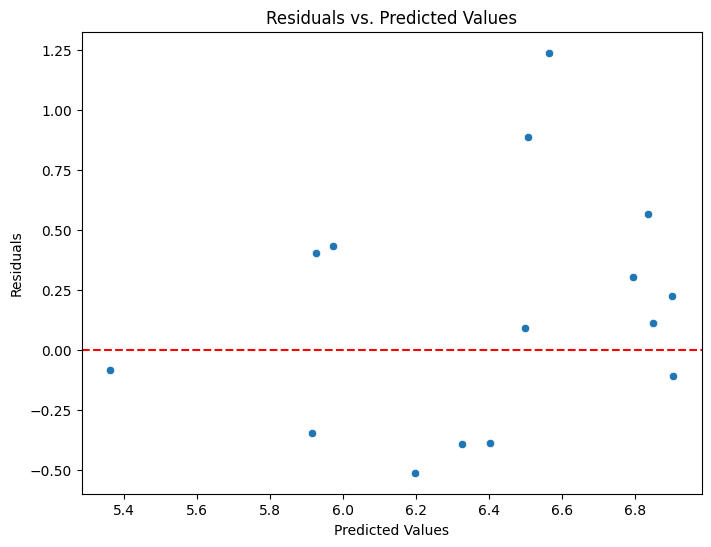

In [7]:
# Calculate residuals
residuals = y_test - y_pred_rf

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Again, our residuals seem to be randomly distributed; however, unlike our residuals for linear regression, our residuals are mostly greater than 0. This means that our random forest regression model is underpredicting the actual values, and there could be some bias in our model. This may also indicate underfitting in our model.

### 3.3 Scatterplot of predictions vs. actual values <a name="#rf-scatter"></a>

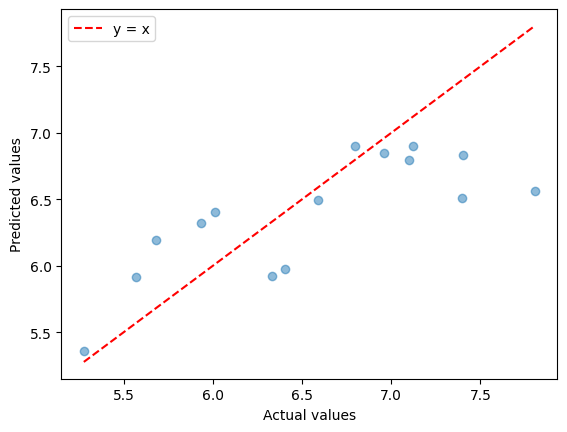

In [8]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

min_val = min(min(y_test), min(y_pred_rf))  # Find the minimum value
max_val = max(max(y_test), max(y_pred_rf))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="y = x")

plt.legend()
plt.show()

While the points in our random forest regression scatterplot for predicted vs. actual values seem to be generally increasing, unlike our linear regression scatterplot, they are not increasing in close alignment with the diagonal.

Our random forest model has shown several weaknesses compared to our linear regression model: it is more sensitive to error, has a large amount of positive residuals which indicates underfitting, and weak diagonal alignment of predicted vs. actual values. Taking all this into account, so far, our linear regression model appears to be the stronger contender. However, to be sure, let's look at one more potential model: the Gradient Boosting Regressor.

## 4 - Model with Gradient Boosting Regressor (GBR) <a name="gbr"></a>

### 4.1 Training and fitting <a name="gbr-train"></a>

In [9]:
# Initialize the model
gbr = GradientBoostingRegressor()

# Fit the model
gbr.fit(X_train, y_train)

# Make predictions
y_pred_gbr = gbr.predict(X_test)

# Evaluate the model using MAE, MSE, and R-squared
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# Output the results
print('Gradient Boosting Regression Results:')
print(f'MAE: {mae_gbr}')
print(f'MSE: {mse_gbr}')
print(f'R-squared: {r2_gbr}')

Gradient Boosting Regression Results:
MAE: 0.5278401590277106
MSE: 0.36018879761890604
R-squared: 0.3200960532577548


Our GBR results are even less impressive than our random forest regression results. With an $R^2$ of 0.3143, this model explains only 31% of the variation from the mean -- even less than our random forest regression model. The MAE and MSE are also similar but slightly higher than they were for our random forest regression model, meaning our GBR model is slightly more sensitive to error.

### 4.2 Residual analysis <a name="gbr-residual"></a>

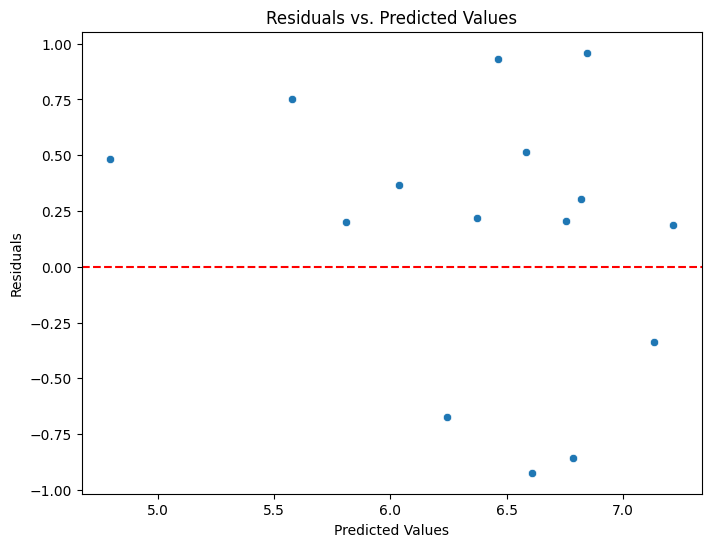

In [10]:
# Calculate residuals
residuals = y_test - y_pred_gbr

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_gbr, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Similar to our random forest regression model, the residuals seem to be mostly above 0, indicating underfitting problems once again.

### 4.3 Scatterplot of predictions vs. actual values <a name="#gbr-scatter"></a>

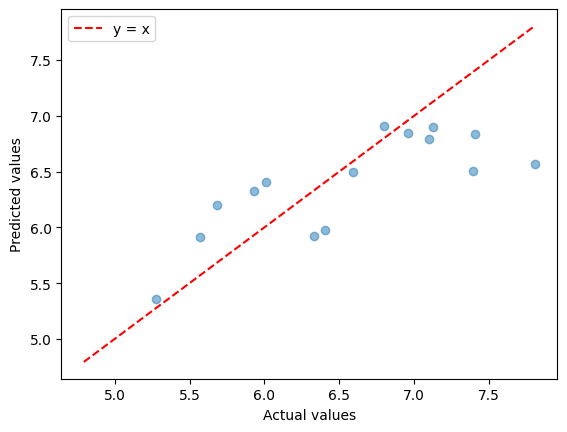

In [11]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

min_val = min(min(y_test), min(y_pred_gbr))  # Find the minimum value
max_val = max(max(y_test), max(y_pred_gbr))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="y = x")

plt.legend()
plt.show()

This scatterplot for predicted vs. actual values strongly resembles the one for random forest regression, meaning it suffers from the same problems. These points are not increasing in close alignment with the diagonal, so our GBR model is not capturing the underlying relationship well.

## 5 - Model Comparison and Evaluation <a name="comparison"></a>

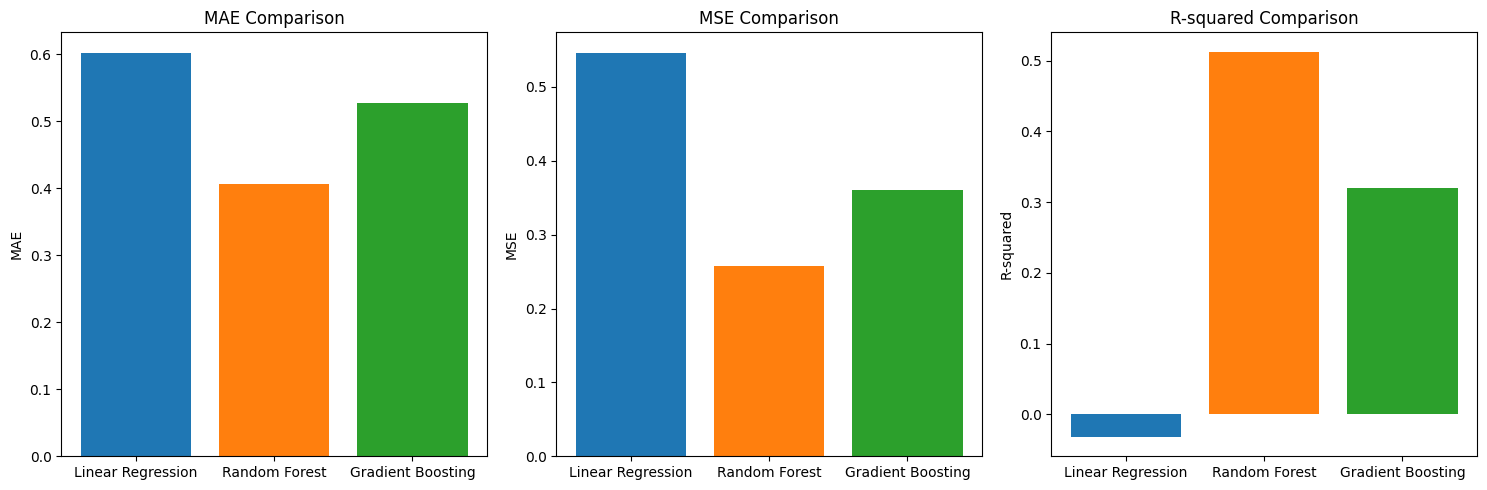

In [12]:
# Metrics from each model
metrics = {
    'Linear Regression': {'MAE': mae, 'MSE': mse, 'R2': r2},
    'Random Forest': {'MAE': mae_rf, 'MSE': mse_rf, 'R2': r2_rf},
    'Gradient Boosting': {'MAE': mae_gbr, 'MSE': mse_gbr, 'R2': r2_gbr}
}

# Extract the metrics for plotting
models = list(metrics.keys())
mae_values = [metrics[model]['MAE'] for model in models]
mse_values = [metrics[model]['MSE'] for model in models]
r2_values = [metrics[model]['R2'] for model in models]

# Set up the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Bar plot for MAE
ax[0].bar(models, mae_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[0].set_title('MAE Comparison')
ax[0].set_ylabel('MAE')

# Bar plot for MSE
ax[1].bar(models, mse_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[1].set_title('MSE Comparison')
ax[1].set_ylabel('MSE')

# Bar plot for R-squared
ax[2].bar(models, r2_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[2].set_title('R-squared Comparison')
ax[2].set_ylabel('R-squared')

# Adjust layout
plt.tight_layout()
plt.show()

We have mentioned previously how linear regression's results have far outperformed our random forest and gradient boosting regression models. To drive this home, we can visually compare these metrics.

MAE and MSE, again, were similarly high for our random forest regression and gradient boosting regression models, indicating high sensitivity to error for both of these models. $R^2$ values were also low for both of these models, indicating that neither one explained variance well.

Our linear regression model, on the other hand, demonstrated low sensitivity to error and reasonably high account for variance. Furthermore, its predicted vs. actual values were in close alignment with the diagonal $y=x$. For these reasons, **we will proceed with using our linear regression model for this project.**

## 6 - Analysis <a name="analysis"></a>

In [13]:
intercept = lin_reg.intercept_
coefficients = lin_reg.coef_

In [14]:
# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

In [15]:
# View the DataFrame
print("Intercept:", intercept)
coef_df.sort_values(by='Coefficient', ascending=False, inplace=True)
coef_df

Intercept: 5.128077342569832


,Feature,Coefficient
42,country_Israel,1.939975
24,country_Denmark,0.996115
38,country_Iceland,0.926022
48,country_Luxembourg,0.919757
72,country_Switzerland,0.916493
...,...,...
61,country_Philippines,-0.899066
36,country_Hong Kong,-1.117337
39,country_India,-1.141086
55,country_Nigeria,-1.506498


In [16]:
# Baseline country identification
all_countries = ['Argentina', 'Australia', 'Austria', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria', 'Canada',
                 'Chile', 'Colombia', 'Costa Rica', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
                 'Egypt', 'El Salvador', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Guatemala',
                 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel',
                 'Italy', 'Japan', 'Kazakhstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico',
                 'Morocco', 'Netherlands', 'New Zealand', 'Nicaragua', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
                 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Saudi Arabia', 'Singapore',
                 'Slovakia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand',
                 'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 
                 'Venezuela', 'Vietnam']

# Get the one-hot encoded country columns (assuming 'X' is your features DataFrame)
encoded_countries = [col.replace('country_', '') for col in df.columns if col.startswith('country_')]

# Find the baseline country
baseline_country = set(all_countries) - set(encoded_countries)
print("Baseline Country:", baseline_country)


Baseline Country: {'Argentina'}


In [17]:
df

,ladder_score,gdp_per_capita,social_support,life_expectancy,life_choice_freedom,generosity,corruption,popularity,is_explicit,duration_ms,...,country_Taiwan,country_Thailand,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Vietnam
0,7.804,10.792,0.969,71.150,0.961,-0.019,0.182,54.241709,21.896163,182422.435666,...,False,False,False,False,False,False,False,False,False,False
1,7.586,10.962,0.954,71.250,0.934,0.134,0.196,57.968539,42.307692,189429.330769,...,False,False,False,False,False,False,False,False,False,False
2,7.530,10.896,0.983,72.050,0.936,0.211,0.668,46.119044,34.222222,197176.773333,...,False,False,False,False,False,False,False,False,False,False
3,7.473,10.639,0.943,72.697,0.809,-0.023,0.708,50.316184,14.979757,209172.384615,...,False,False,False,False,False,False,False,False,False,False
4,7.403,10.942,0.930,71.550,0.887,0.213,0.379,65.088140,29.573935,187203.403509,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,4.903,8.973,0.553,63.901,0.787,-0.231,0.811,55.046564,53.679654,191800.484848,...,False,False,False,False,False,False,False,False,False,False
67,4.614,10.307,0.796,68.663,0.475,-0.077,0.795,65.592845,18.226601,173797.334975,...,False,False,True,False,False,False,False,False,False,False
68,4.555,8.540,0.601,57.313,0.766,0.008,0.787,65.561595,12.437811,216097.870647,...,False,False,False,False,False,False,False,False,False,False
69,4.170,9.367,0.726,63.503,0.732,-0.183,0.580,53.368537,13.333333,218889.055556,...,False,False,False,False,False,False,False,False,False,False
